## Error Analysis for Meander 

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np 
from scipy import stats

#### Get river discharge and meander wavelength data from Segment files

In [2]:
folder = r'D:\MS Sinuosity Data\Segments'

names = pd.read_csv(os.path.join(folder, 'data_descriptions.txt'), sep = ',', header = None)
names.set_index(0)

segs = os.listdir(folder)
vars_to_get = ['Meandwave', 'mean_dis', 'max_dis', 'min_dis', 'rec2', 'rec10', 'rec20', 'lat', 'lon']
df = pd.DataFrame(index = vars_to_get)
for s in segs:
    if s != 'data_descriptions.txt' and s[0] != '~':
        path = os.path.join(folder, s)
        data = pd.read_excel(path)

        ind = list(names[0]).index(s[:-5])
        location = names.iloc[ind][1]
        
        data_mean = [np.mean(data[x]) for x in vars_to_get]
        
        df[location] = data_mean

df = df.transpose()
print(df.index)
#df = df.drop(["Amazon main trunk ", "north Amazon", "Yangtze", "west Amazon", "Amur"])
df
df.to_excel(r'D:\MS Sinuosity Data\file.xlsx')

Index(['Amazon main trunk ', 'west fork kickapoo', 'Small CreekOR',
       'Red River', 'wabash', 'west Amazon', 'north Amazon', 'Yangtze',
       'Little Yeinsen', 'Amur', 'smaller part of Amazon ', 'Kansas',
       'missouri', 'mississippi', 'brandywine ', 'animas ', 'baker riverNH ',
       'snake riverMA'],
      dtype='object')


#### Visualize data

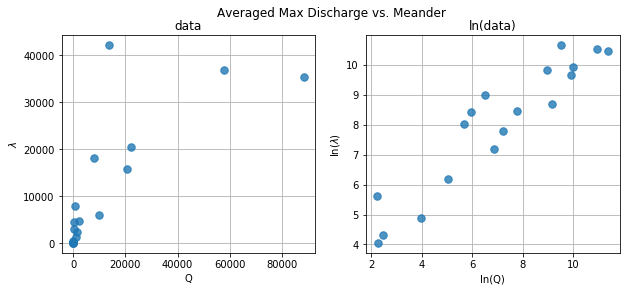

In [3]:
plt.figure(1, figsize = (10, 4))
plt.suptitle('Averaged Max Discharge vs. Meander')
plt.subplot(1,2,1)
plt.plot(df['max_dis'], df['Meandwave'], '.', markersize = 15, alpha = 0.8)
plt.title('data')
plt.ylabel('$\lambda$')
plt.xlabel('Q')
plt.grid()

plt.subplot(1,2,2)
plt.title('ln(data)')
plt.plot(np.log(df['max_dis']), np.log(df['Meandwave']), '.', markersize = 15, alpha = 0.8)
plt.ylabel('ln($\lambda$)')
plt.xlabel('ln(Q)')
plt.grid()

#### Calculating _a_ and _b_ 
From Leopold and Wolman we know that: 
$$ \lambda = aQ ^ b$$
Taking the natural log of each side 
$$ ln(\lambda) = ln(a) + b \, ln(Q) $$
which is a linear equation. \
Therefore, if we take the linear regression of $ln(Q)$ with respect to $ln(\lambda)$ 
$$ a = e^{intercept}$$
$$ b = slope $$

#### Linear Regression Results
These slope and intercept values match the acquired slope and intercept values when this data is plugged into excel and a trendline is calculated with a power function trend

In [5]:
results = stats.linregress(np.log(df['max_dis']), np.log(df['Meandwave']))
print(results)
r_df = pd.DataFrame(results, index = ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'])
r_df


LinregressResult(slope=0.6827737994082538, intercept=3.1992297796408824, rvalue=0.9379622933822703, pvalue=9.071477018767685e-09, stderr=0.06310038438195498)


,0
slope,6.827738e-01
intercept,3.199230e+00
rvalue,9.379623e-01
pvalue,9.071477e-09
stderr,6.310038e-02


#### Error Analysis 


(0, 60000)

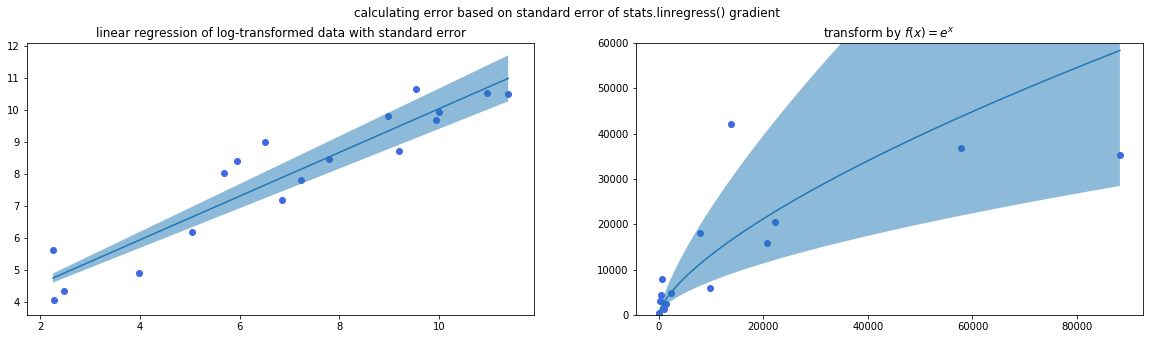

In [6]:
plt.figure(figsize = (20, 5))
plt.suptitle('calculating error based on standard error of stats.linregress() gradient')
plt.subplot(1,2,1)
plt.title('linear regression of log-transformed data with standard error')
x = np.linspace(min(np.log(df.max_dis)), np.log(max(df.max_dis)), 1000)
y = results.slope * x + results.intercept
y1 = (results.slope + results.stderr) * x + results.intercept
y2 = (results.slope - results.stderr) * x + results.intercept
plt.plot(x, y)
plt.scatter(np.log(df['max_dis']), np.log(df['Meandwave']), color = 'royalblue')
plt.fill_between(x, y1, y2, alpha = 0.5)

plt.subplot(1,2,2)
plt.title('transform by $f(x) = e ^ x$ ')
x_trans = np.exp(x)
y_trans = np.exp(y)
y1_trans = np.exp(y1)
y2_trans = np.exp(y2)
plt.scatter(df.max_dis, df.Meandwave, color = 'royalblue')
plt.plot(x_trans, y_trans)
plt.fill_between(x_trans, y1_trans, y2_trans, alpha = 0.5)
plt.ylim(0, 60000)

24.51364201785474
0.6827737994082538


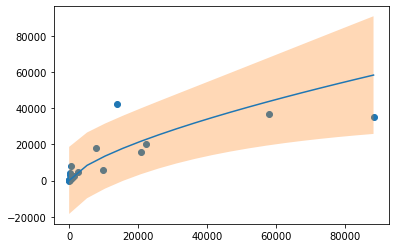

In [7]:
#https://markthegraph.blogspot.com/2015/05/using-python-statsmodels-for-ols-linear.html
a = np.exp(results.intercept)
b = results.slope
def function(x):return a*x**b 
x_pred = np.linspace(df.max_dis.min(), df.max_dis.max(), len(df.max_dis))
y_pred = [function(m) for m in x_pred]
y_err = y_pred - df.Meandwave
mean_x = df.max_dis.mean()
n = len(x_pred)
dof = n - 2
t = stats.t.ppf(1 - 0.025, df = dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
upper = y_pred + abs(conf)
lower = y_pred - abs(conf)

plt.figure()
plt.scatter(df.max_dis, df.Meandwave)
plt.plot(x_pred, y_pred)
plt.fill_between(x_pred, upper, lower, alpha = 0.3)

print(a)
print(b)

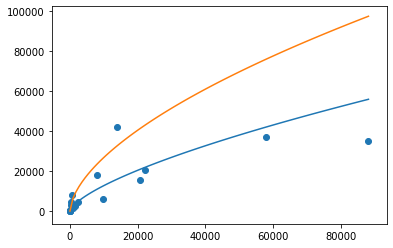

In [94]:
a = np.exp(3.19)
b = 0.68
x = np.linspace(0, max(df.max_dis), 100)
y = [a*x1**b for x1 in x]
a = 114
b = 0.593
y1 = [a*x1**b for x1 in x]
plt.plot(x,y)
plt.plot(x, y1)
plt.scatter(df.max_dis, df.Meandwave)

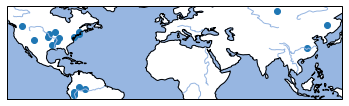

In [15]:
import cartopy 
import cartopy.crs as ccrs

plt.figure()

ax = plt.subplot(projection = ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.OCEAN)
plt.scatter(df['lon'], df['lat'])